# Exercise Sheet 4 - Transfer Learning for Saliency Prediction

 * Deep Learning – Winter term 2020/21
 * Instructor: Alexander Ecker
 * Tutors: Max Burg, Laura Pede
 * Teaching assistants: Clara Holzhüter, Pronaya Prosun Das
 * Due date: **Tue, Jan 12, 14:15**

In this assignment you will learn how to use transfer learning to predict where people will look in images. We will work with the MIT 1003 dataset which consists of 1003 images together with fixation data from human subjects. Transfer learning allows us to reuse the features from a model that has been pretrained on a larger dataset. Here we will use VGG19 pretrained on ImageNet.

The goals of this assignment are as follows:

*   Extract features from a model pretrained on ImageNet.
*   Implement a simple readout network and train it on the data.
*   Define a loss function and a seperate evaluation metric.
*   Visualize the best and the worst results.

## Hints

To understand the idea of the exercise sheet, inspired by a paper called DeepGaze I, do the following.

* Review the lecture
* Tt will be very helpful to read the according paper [Kümmerer, Theis, and Bethge (2015)](https://arxiv.org/abs/1411.1045). 

Although the general idea of the exercise will be the same, we changed some details: for example, we will use VGG instead of caffe net, will not do the same thoroughly analysis and changed some other details as well to make this exercise simpler.

*Do not hesitate to ask questions and ideally discuss them with your fellow students on Rocket Chat! We will monitor the channel to provide you help if your discussions get stuck.*

### IMPORTANT SUBMISSION INSTRUCTIONS

- When you're done, download the notebook and rename it to \<surname1\>_\<surname2\>_\<surname3\>.ipynb
- Only submit the ipynb file, no other file is required
- Submit only once
- The deadline is strict
- You are required to present your solution in the tutorial; submission of the notebook alone is not sufficient

Implementation
- Only change code to replace placeholders. Leave the other code as is. In addition to the python packages loaded below you are allowed to use any packages you want.

**Importing required libraries.**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from skimage import io, transform
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from scipy.ndimage import gaussian_filter

**Get the data**

The MIT 1003 dataset is publicly available at https://people.csail.mit.edu/tjudd/WherePeopleLook/index.html

For your convenience there is a shared folder on Google Drive: https://drive.google.com/drive/folders/1GoYw3jp9kWLmHN7qylDS5QTo_ebnaMDD?usp=sharing
You can click the link and add the folder to your Drive (it does not count into your disk quota).

If you're using Colab, you can uncomment the code in the following cell to mount your Google drive. Otherwise, you need to download the data and enter the path to it.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
main_path = '/content/drive/MyDrive/Deep_Learning_Lecture/Colab_Notebooks'
data_path = os.path.join(main_path, 'MIT_1003')
data_path

'/content/drive/MyDrive/Deep_Learning_Lecture/Colab_Notebooks/MIT_1003'

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')

**Prepare the data**

In [ ]:
images_files_all  = [os.path.join(data_path, 'ALLSTIMULI', f) for f in os.scandir(os.path.join(data_path, 'ALLSTIMULI')) if f.path.endswith('.jpeg') ]
print ("Total Number of Images: {} (should be 1003)".format(len(images_files_all)))

Total Number of Images: 1003 (should be 1003)


In [ ]:
# fix the seed for reproducible splitting
np.random.seed(1234)
train_idx = np.random.choice(len(images_files_all), len(images_files_all)//2, replace=False)
test_idx = np.setdiff1d(np.arange(len(images_files_all)), train_idx)

images_files = {}
images_files['train'] = [images_files_all[i] for i in train_idx]
images_files['test'] = [images_files_all[i] for i in test_idx]
print ("Number of Train Images: {}".format(len(images_files['train'])))
print ("Number of Test Images: {}".format(len(images_files['test'])))

fixation_maps_binary_files = {}
fixation_maps_binary_files['train']  = [os.path.join(data_path, 'ALLFIXATIONMAPS', os.path.splitext(os.path.basename(filename))[0] + '_fixPts.jpg') for filename in images_files['train']]
fixation_maps_binary_files['test']  = [os.path.join(data_path, 'ALLFIXATIONMAPS', os.path.splitext(os.path.basename(filename))[0] + '_fixPts.jpg') for filename in images_files['test']]
fixation_maps_blurred_files = {}
fixation_maps_blurred_files['train'] = [os.path.join(data_path, 'ALLFIXATIONMAPS', os.path.splitext(os.path.basename(filename))[0] + '_fixMap.jpg') for filename in images_files['train']]
fixation_maps_blurred_files['test'] = [os.path.join(data_path, 'ALLFIXATIONMAPS', os.path.splitext(os.path.basename(filename))[0] + '_fixMap.jpg') for filename in images_files['test']]

Number of Train Images: 501
Number of Test Images: 502


**Show an example from the dataset**

In [ ]:
image = io.imread(images_files['train'][5])
binary_map = io.imread(fixation_maps_binary_files['train'][5])
blurred_map = io.imread(fixation_maps_blurred_files['train'][5])

In [ ]:
print(np.shape(image)) # H x W x C
print(np.shape(blurred_map))
print(np.shape(binary_map))

(768, 1024, 3)
(768, 1024)
(768, 1024)


In [ ]:
print(np.max(image), np.min(image))
print(np.max(blurred_map), np.min(blurred_map))
print(np.max(binary_map), np.min(binary_map))

255 0
255 0
255 0


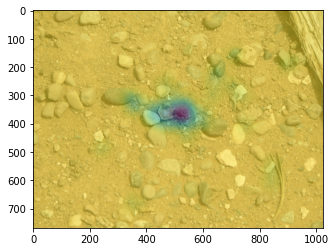

In [ ]:
plt.imshow(image)
plt.imshow(blurred_map, alpha=0.5, cmap='viridis_r')

In [ ]:
fixations = np.where(binary_map)

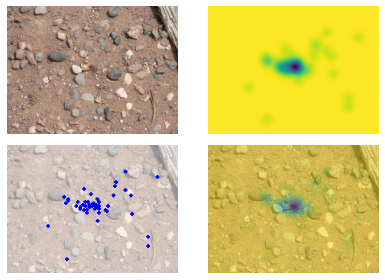

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
ax1.axis('off')
ax1.imshow(image)
ax2.axis('off')
ax2.imshow(blurred_map, cmap='viridis_r')
ax3.axis('off')
ax3.imshow(image, alpha=0.5)
ax3.scatter(fixations[1], fixations[0], s=1, marker='.', c='b')
ax4.axis('off')
ax4.imshow(image)
ax4.imshow(blurred_map, alpha=0.5, cmap='viridis_r')
fig.tight_layout()

**Preprocess images and maps**

The images have different sizes and orientations. To simplify our task we downscale the images and crop them to a size of 256x256 pixels. At this size, all of the images should fit into memory at once.

In [ ]:
def preprocess_data(images_paths, fixations_binary_paths, fixations_blurred_paths, shape):
    transform = torchvision.transforms.Compose([torchvision.transforms.ToPILImage(), 
                                                    torchvision.transforms.Resize(shape), 
                                                    torchvision.transforms.CenterCrop(shape)])
    
    n = len(images_paths)
    ims = np.empty((n, shape, shape, 3), dtype=np.int)
    fixs_binary = np.empty((n, shape, shape))
    fixs_blurred = np.empty((n, shape, shape))

    for i, path in enumerate(tqdm(images_paths)):
        image = io.imread(path)
        image = transform(image)
        image = np.array(image, dtype=np.int)
        ims[i] = image

    for i, path in enumerate(tqdm(fixations_binary_paths)):
        fixations_binary = io.imread(path, 0)
        fixations_binary = transform(fixations_binary)
        fixations_binary = np.array(fixations_binary)
        fixs_binary[i] = fixations_binary
    
    for i, path in enumerate(tqdm(fixations_blurred_paths)):
        fixations_blurred = io.imread(path, 0)
        fixations_blurred = transform(fixations_blurred)
        fixations_blurred = np.array(fixations_blurred)
        fixs_blurred[i] = fixations_blurred
        
    data = {'images': ims, 'fixations_binary': fixs_binary, 'fixations_blurred': fixs_blurred}
    return data

In [ ]:
train_data = preprocess_data(images_files['train'], fixation_maps_binary_files['train'], fixation_maps_blurred_files['train'], 256)

100%|██████████| 501/501 [03:30<00:00,  2.38it/s]


**Save/Load preprocessed data**

If you want to, you can save the data on disk, so that you don't have to generate it again.

In [ ]:
train_data_file = os.path.join(main_path, 'train_data.npy')
#np.save(train_data_file, train_data)
train_data = np.load(train_data_file, allow_pickle=True)[()]

In [ ]:
print(train_data['images'].shape)
print(train_data['fixations_blurred'].shape)
print(train_data['fixations_binary'].shape)

(501, 256, 256, 3)
(501, 256, 256)
(501, 256, 256)


**Implement a PyTorch dataset for our data**

This allows us to access the data conveniently and to use it in a dataloader.

In [ ]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, preprocessed_data, features=None):
        self.features = features
        self.data = preprocessed_data
    
    def __getitem__(self, key):
        raw_image = self.data['images'][key]
        
        normalized_image = raw_image.astype(np.float32) / 255.0 # -> [0, 1]
        normalized_image -= np.array([0.485, 0.456, 0.406])     # subtract mean
        normalized_image /= np.array([0.229, 0.224, 0.225])     # divide by SD   
        normalized_image = normalized_image.transpose(2, 0, 1)  # HWC -> CHW
        
        fixations_binary = self.data['fixations_binary'][key]
        fixations_blurred = self.data['fixations_blurred'][key]

        data = {
            "raw_image": raw_image,
            "normalized_image": normalized_image,
            "fixations_binary": fixations_binary,
            "fixations_blurred": fixations_blurred
        }

        if self.features is not None:
            data["features"] = self.features[key]

        return data
    
    def __len__(self):
        return len(self.data['images'])

The collate_fn will be used in the dataloader. It converts the batched data into tensors. We use a sparse tensor for the binary fixations because they contain mostly zeros.

In [ ]:
def to_sparse(x):
    """ converts dense tensor x to sparse format """
    x_typename = torch.typename(x).split('.')[-1]
    sparse_tensortype = getattr(torch.sparse, x_typename)

    indices = torch.nonzero(x)
    if len(indices.shape) == 0:  # if all elements are zeros
        return sparse_tensortype(*x.shape)
    indices = indices.t()
    values = x[tuple(indices[i] for i in range(indices.shape[0]))]
    return sparse_tensortype(indices, values, x.size())

def collate_fn(batch):
    batch_data = {
        "image": torch.tensor([item["normalized_image"] for item in batch]),
        "fixations_binary": to_sparse(torch.tensor([item["fixations_binary"] for item in batch])),
        "fixations_blurred": torch.tensor([item["fixations_blurred"] for item in batch])
    }
    if "features" in batch[0].keys():
        batch_data["features"] = torch.tensor([item["features"] for item in batch], dtype=torch.float)
    return batch_data

**Compute center bias**

People tend to look towards the center of the image. This is both due to a bias in our expectations as well as the tendency of photographers to place the interesting objects in the center of the photo. Thus, in the fixation data there is a bias towards the center of the image. We incorporate this bias into our model explicitly. 

**TO DO:** To compute the center bias, 
1. sum all the binary fixation maps, 
1. normalize by dividing through the maximum value
1. apply a Gaussian filter with standard deviation 10 to smooth the result
1. and compute the natural logarithm

*Hints:*
- Use the `ImageDataset` class to directly access the data; no pytorch data loader is required here.
- For Gaussian filtering, you can use `gaussian_filter` from `scipy.ndimage`

In [ ]:
from scipy.ndimage import gaussian_filter

dataset_train = ImageDataset(train_data)
fixations_binary = dataset_train.data['fixations_binary']

(501, 256, 256, 3)
(3, 256, 256)
(501, 256, 256)


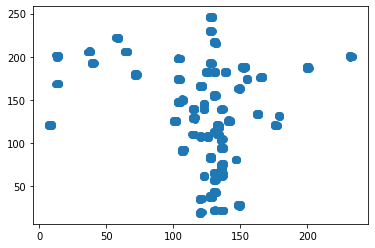

In [ ]:
plt.scatter(np.where(fixations_binary[1,:,:])[0],np.where(fixations_binary[1,:,:])[1])
print(dataset_train.data['images'].shape)
print(dataset_train[0]['normalized_image'].shape)
print(fixations_binary.shape)

In [ ]:
#TODO
center_bias = gaussian_filter(np.sum(fixations_binary, 0)/np.max(fixations_binary), sigma=10)    # (should be 1 x 256 x 256)
center_bias = np.log(center_bias.reshape((1,256,256)))

Plot the result

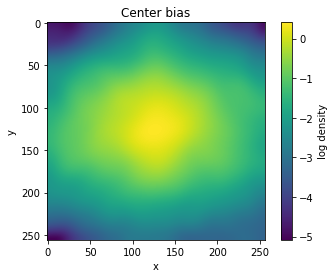

In [ ]:
plt.figure()
plt.imshow(center_bias[0])
cb = plt.colorbar().set_label('log density')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Center bias');

Your plot should look like this:

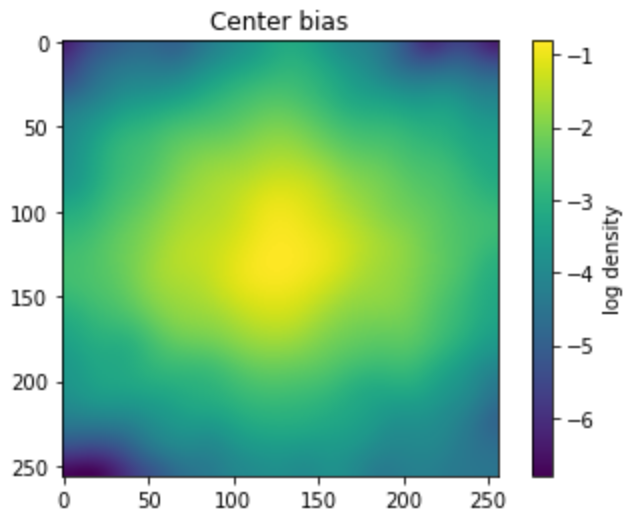

Save/Load center bias

In [ ]:
center_bias_file = os.path.join(main_path, 'center_bias.npy')
#np.save(center_bias_file, center_bias)
center_bias = np.load(center_bias_file)

**Extract feature maps**

Load the VGG19 model pretrained on ImageNet. Use it to process the images in the train dataset and extract the feature maps from the Conv2d layer `vgg19.features[30]`. You should save them in a Numpy array of shape `(num_samples, num_features, x, y)`.

**Theory question and hint**:
- Which shape do you expect for the numpy array? Calculate the values by hand **(501 x 512 x 16 x 16)**
- You can verify that you calculated correctly with the code you will write for this task

*Hints:*
- Here you will have to define and use a pytorch `DataLoader` object
    - feed in the train set
    - use the `collate_fn` defined above
    - do not shuffle the data points, so we can save the features and when reusing them later can still identify the features with the images used to create them
- cf. https://pytorch.org/docs/stable/torchvision/models.html. If you are wondering if we normalized images, check code in `ImageDataset`
- Define a `feature_extractor` object, containing those parts of the pre-trained VGG19 models that you need to textract the feature maps from the Conv2d layer `vgg19.features[30]`
    - Don't forget to put your feature extractor in evaluation mode

In [ ]:
#TODO
vgg = models.vgg19(pretrained=True).to(device)
print(vgg.features[0:31])
feature_extractor = nn.Sequential(vgg.features[0:31])
#feature_extractor(torch.from_numpy(dataset_train[0]['normalized_image']).view(1,3,256,256)).shape

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth



Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPo

In [ ]:
features = []
with torch.no_grad():
  for item in range(len(dataset_train)):
    foo = feature_extractor(torch.from_numpy(dataset_train[item]['normalized_image']).view(1,3,256,256).to(device))
    
    features.append(np.array(foo.view(512,16,16).to('cpu')))
    if (item + 1) % 50 == 0:
      print(f'extract features from image {item+1} / {len(dataset_train)}')

extract features from image 50 / 501
extract features from image 100 / 501
extract features from image 150 / 501
extract features from image 200 / 501
extract features from image 250 / 501
extract features from image 300 / 501
extract features from image 350 / 501
extract features from image 400 / 501
extract features from image 450 / 501
extract features from image 500 / 501


In [ ]:
features = np.array(features)
print(features.shape)

(501, 512, 16, 16)


**Save the features to a file**

Processing the images can take a few minutes. However, you only have to do it once. Thus it is a good idea to save the features to a file that you can load again later.

In [ ]:
features_file = os.path.join(main_path, 'features_train.npy')
# np.save(features_file, features)
features = np.load(features_file)

Add the features to the dataset and define a data loader for training our model. Feel free to change the batch size.

In [ ]:
dataset_train = ImageDataset(train_data, features=features)

data_loader_train = torch.utils.data.DataLoader(
    dataset_train,
    shuffle=False,
    batch_size=64,
    collate_fn=collate_fn,
    pin_memory=False,
)

In [ ]:
tmp0 = iter(data_loader_train)
tmp_dat = tmp0.next()
print(tmp_dat['features'].shape)
print(tmp_dat['fixations_binary'].shape)
print(tmp_dat['fixations_blurred'].shape)
print(tmp_dat['image'].shape)

torch.Size([64, 512, 16, 16])
torch.Size([64, 256, 256])
torch.Size([64, 256, 256])
torch.Size([64, 3, 256, 256])


**Define the model**

Now we need to define the model we want to train. Two parts are necessary:

1. Readout Network

The readout network gets the feature maps we extracted from VGG19 as input. The network could be of arbitrary complexity but in our case we want to keep it simple: it contains only one layer that takes a linear combination of the features at each location (using 1x1 convolution).

2. Finalizer

The finalizer takes the output of the readout network and scales it up to the size of our images (256x256). It then applies a Gaussian filter to blur the result of the upscaling and adds the center bias. Finally, it performs normalization using a (log) softmax to return the logarithm of the fixation probability densities, later refered to as `log_density`.

*Hints:*
- What are in- and out-shapes of the readout network? What are the parameters you have to pass to the constructor of the 1x1 convolution, then?
- Don't forget to give a learnable weight to the center bias, $\alpha$ in [Kümmerer, Theis, and Bethge (2015)](https://arxiv.org/abs/1411.1045). 
- In `Finalizer` below, initialize `self.gaussian_blur = GaussianBlur2d()` and use `self.gaussian_blur` in `forward(...)`.
- You might want to use `F.interpolate`
- The finalizer output is of shape `(batch, x_pixels, y_pixels)`
- Log softmax: As the finalizer should return the logarithm of the fixation probabilities, here is a hint rewriting the math of the paper cited above accordingly:
$$\ln p(x, y)=\ln \frac{\exp (o(x, y))}{\sum_{x, y} \exp (o(x, y))} = \ ?$$
$$ = o(x, y) - \ln \sum_{x, y} \exp (o(x, y))$$
(Note that in the paper $\log$ refers to the natural logarithm $\ln$. Ignore the regularization term in this step). Hence, we recommend you to use `logsumexp` to compute the softmax in log-space.

In [266]:
class GaussianBlur2d(nn.Module):
    """
    This class applies a Gaussian filter to a tensor. You should 
    use it *after* upscaling to image size (256x256). The kernel
    size and the standard deviation are fixed and you don't need
    to change them.
    """
    
    def __init__(self):
        super().__init__()

        self.kernel_size = 121
        self.sigma = 20
        self.pad = 60

        grid = torch.arange(float(self.kernel_size)) - self.pad

        kernel_shape_x = [1] * 4
        kernel_shape_x[3] = self.kernel_size
        grid_x = grid.view(kernel_shape_x)
        self.kernel_x = torch.exp(-0.5 * (grid_x / self.sigma) ** 2)#.cuda()
        self.kernel_x = self.kernel_x / self.kernel_x.sum()

        kernel_shape_y = [1] * 4
        kernel_shape_y[2] = self.kernel_size
        grid_y = grid.view(kernel_shape_y)
        self.kernel_y = torch.exp(-0.5 * (grid_y / self.sigma) ** 2)#.cuda()
        self.kernel_y = self.kernel_y / self.kernel_y.sum()

        
    def forward(self, tensor):
        """Applies the gaussian filter to the given tensor"""
        out = F.conv1d(tensor, self.kernel_x, padding=self.pad)
        out = F.conv1d(out, self.kernel_y)

        return out

In [267]:
#TODO
readout_network = nn.Conv2d(512, 1, kernel_size=(1, 1))

In [268]:
class Finalizer(nn.Module):
    """Returns logarithm of the fixation probability densities, shape: (batch, x_size, y_size)"""

    def __init__(self):
      super().__init__()
      self.alpha   = torch.nn.Parameter(torch.randn(1))
      self.alpha.requires_grad = True
      self.gaussian_blur = GaussianBlur2d()

    def forward(self, x, centerbias):
      x = self.gaussian_blur(F.interpolate(input=x, size=(256, 256))).view(-1, 256, 256)
      #print(self.alpha.shape, centerbias.shape)
      x += self.alpha * centerbias 
      x = x - torch.logsumexp(x, (1,2))[:, None, None]
      return x

In [269]:
class Model(nn.Module):
    
    def __init__(self, readout_network, finalizer):
        super().__init__()
        self.readout_network = readout_network
        self.finalizer = finalizer
        
    def forward(self, x, centerbias):
        x = self.readout_network(x)
        x = self.finalizer(x, centerbias)
        return x

    def train(self, mode=True):
        self.readout_network.train(mode=mode)
        self.finalizer.train(mode=mode)

In [ ]:
finalizer = Finalizer()
model = Model(readout_network, finalizer)

**Define the metrics**

We use two different metrics, one for training and one for evaluating the performance of our model. Remember that we did this for the past exercises, too: back then, we used the cross-entropy loss for training and accuracy for validation.

Here, for the training, we use negative log-likelihood (NLL). Implement a function that calculates the negative log-likelihood of a fixation mask (which are the labels in our data) under the model prediction `log_density` (i.e. the logarithm of the fixation probability density maps). 

*Hints:* 
The negative log-likelihood we want to use is a slight modification of the equation (last one on page 3) given in Kümmerer, Theis, and Bethge (2015). Ignoring the regularization term, we obtain

$$c(\alpha, w)=-\frac{1}{N} \sum_{i=1}^{N} \ln \hat{p}\left(x_{i}, y_{i}\right) \ .$$

Furthermore, note that we sum the model's fixation probability prediction $\hat{p}$ over the fixation points $(x_i,y_i)$ measured in the experiments, i.e. over the $N$ non-zero entries in the binary fixation masks (our labels). Let's rewrite this in a way you can directly implement into code: We compute the inner product of the model predictions at all spatial coordinates $\hat{p}(x_j, y_k)$ and ground truth binary fixation masks $f(x_j, y_k)$, 

$$c(\alpha, w)=-\frac{1}{N} \sum_{i=1}^N \sum_{j,k} \ln (\hat{p}(x_{j,i}, y_{k,i})) \cdot f(x_{j,i},y_{k,i})  \ ,$$

with $N$ being the number of non-zero elements in the sum. For implementation, you may want to
- Convert the sparse binary `fixation_mask` to a dense one using `t.to_dense()` to be able to compute the inner product of $f$ with the predictions $\hat{p}$.
- Compute the mean across batches

In [ ]:
finalizer = Finalizer()
model_tmp = Model(readout_network, finalizer)
model_tmp(tmp_dat['features'], torch.from_numpy(center_bias)).shape

torch.Size([64, 256, 256])

In [ ]:
mask_temp = tmp_dat['fixations_binary']
mask_temp = mask_temp.to_dense()
mask_temp.shape,pred.shape

(torch.Size([64, 256, 256]), torch.Size([64, 256, 256]))

In [279]:
out = 0
log_density = pred
for b in range(mask_temp.shape[0]):
  #idx = mask_temp[b,:,:].nonzero(as_tuple=True)
  #out -= torch.dot(log_density[b,idx[0],idx[1]], mask_temp[b,idx[0],idx[1]].to(torch.float32))/len(idx[0])
  out -= torch.matmul(log_density[b,:,:], mask_temp[b,:,:].to(torch.float32)).mean()
out/64

tensor(181.3748, grad_fn=<DivBackward0>)

In [ ]:
mask_temp[0,:,:].shape

torch.Size([256, 256])

In [239]:
torch.matmul(log_density[b,:,:], mask_temp[0,:,:].to(torch.float32)).mean()

tensor(-135.0136, grad_fn=<MeanBackward0>)

In [240]:
#np.where(mask_temp[0,:,:])

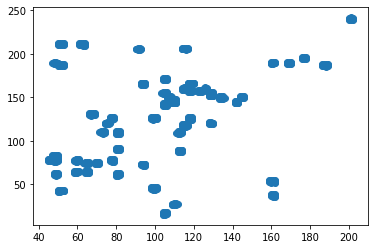

In [ ]:
#plt.scatter(np.where(mask_temp[0,:,:])[0],np.where(mask_temp[0,:,:])[1])

In [270]:
def neg_log_likelihood(log_density, fixation_mask):
  fixation_mask = fixation_mask.to_dense()
  out = 0
  batch_size = fixation_mask.shape[0]
  for b in range(batch_size):
    #idx = fixation_mask[b,:,:].nonzero(as_tuple=True)
    #out -= torch.dot(log_density[b,idx[0],idx[1]], fixation_mask[b,idx[0],idx[1]].to(torch.float32))/len(idx[0])
    out -= torch.matmul(log_density[b,:,:], fixation_mask[b,:,:].to(torch.float32)).mean()
  return out/batch_size

For evaluation, we want to use the *normalized scanpath saliency* (NSS; [Peters, Iyer, Itti, and Koch (2005), Section 2.10](https://doi.org/10.1016/j.visres.2005.03.019)). To compute NSS, normalize the model's saliency map (prediction) $\mathrm{SM}(x,y)$ to have zero mean and unit standard deviation,

$$Z_{\mathrm{SM}}(x,y) = \frac{\mathrm{SM}(x,y) - \mu}{\sigma}\ ,$$

where $\mu$ and $\sigma$ are the mean and the standard deviation of the saliency map, respectively. Then, average the according responses at all fixations $(x_i,y_i)$,

$$\mathrm{NSS} = \frac{1}{N} \sum_{i=1}^N Z_{\mathrm{SM}}(x_i,y_i)\ .$$ 

Implement this as a function.

*Hints:*
- Here, the saliency map $\mathrm{SM}(x,y)$ is *not* in log-space, i.e. the saliency map is given as exponential of the `log_density` that the model would predict, $\mathrm{e}^{\hat{p}(x, y)}$.
- Remember the hints from above: 
    - How can you rewrite/implement the sum over fixation points in terms of a inner product of the normlized saliency map and the binary fixation mask?
    - Compute the mean across batches

In [260]:
density = torch.exp(log_density)

stand_density = density - torch.mean(density, (1,2))[:, None, None]
stand_density = stand_density/torch.std(density, (1,2))[:, None, None]

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], grad_fn=<StdBackward1>)

In [271]:
def nss(log_density, fixation_mask):
    #TODO
    density = torch.exp(log_density)
    stand_density = density - torch.mean(density, (1,2))[:, None, None]
    stand_density = stand_density/torch.std(density, (1,2))[:, None, None]
    
    fixation_mask = fixation_mask.to_dense()
    out = 0
    batch_size = fixation_mask.shape[0]
    batch_size = fixation_mask.shape[0]
    for b in range(batch_size):
      out += torch.matmul(stand_density[b,:,:], fixation_mask[b,:,:].to(torch.float32)).mean()
    return out/batch_size

**Train the model**

Now iterate through the dataloader to train the model on the train dataset. You can use the Adam optimizer with default parameters. You should print the NLL and the NSS of the train dataset after each training epoch to monitor the progress. Train for at least 5 epochs. You are welcome to reuse and adapt the code you used on the previous exercise sheets for model training, but you don't have to.

*Hints:*
- Do we want to maximize or minimize the negative log-likelihood? **minimize**
- In our reference implementation, after the fifth epoch we got `NLL: 10.0   NSS: 3.9`

In [275]:
def train_model(model, train_dataset, num_epoch, centerbias, optimizer, scheduler=None):
    #TODO
    #epoch_NLL = []
    #epoch_NSS = []
    num_iter = np.ceil(501/64)

    for epoch in range(num_epoch):
      for i, dataloader in enumerate(train_dataset):
        optimizer.zero_grad()
        model.train()

        features = dataloader['features']
        fixations = dataloader['fixations_binary']
        
        pred = model(features, centerbias)
        NLL  = neg_log_likelihood(pred, fixations)
        NSS  = nss(pred, fixations)

        NLL.backward()
        optimizer.step()
        
        if scheduler:
          scheduler.step()

        #epoch_NLL.append(nll.item())

        print(f'Epoch [{epoch+1}/{num_epoch}], Step {i+1}/{num_iter}, NLL: {NLL.item():.2f}, NSS: {NSS.item():.2f}' )
        
    return 0

In [ ]:
centerbias = torch.tensor(center_bias, dtype=torch.float)
for i, dataloader in enumerate(data_loader_train):
  features = dataloader['features']
  fixations = dataloader['fixations_binary']
  print(features.shape, fixations.shape)
  
  pred = model(features, centerbias)
  print(pred.shape)

torch.Size([64, 512, 16, 16]) torch.Size([64, 256, 256])
torch.Size([1]) torch.Size([1, 256, 256])
torch.Size([64, 256, 256])
torch.Size([64, 512, 16, 16]) torch.Size([64, 256, 256])
torch.Size([1]) torch.Size([1, 256, 256])
torch.Size([64, 256, 256])
torch.Size([64, 512, 16, 16]) torch.Size([64, 256, 256])
torch.Size([1]) torch.Size([1, 256, 256])
torch.Size([64, 256, 256])


KeyboardInterrupt: ignored

In [276]:
num_epoch = 5
lr_initial = 1e-1
finalizer = Finalizer()
model = Model(readout_network, finalizer)
optimizer = torch.optim.Adam(model.parameters(), lr=lr_initial)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[3, 4], gamma=0.1)

In [278]:
#%time 
train_model(model, data_loader_train, num_epoch=num_epoch, centerbias=torch.tensor(center_bias, dtype=torch.float), optimizer=optimizer, scheduler=scheduler)

Epoch [1/5], Step 1/8.0, NLL: 169.64, NSS: 2.23
Epoch [1/5], Step 2/8.0, NLL: 1490.67, NSS: -0.18
Epoch [1/5], Step 3/8.0, NLL: 389.60, NSS: 0.56
Epoch [1/5], Step 4/8.0, NLL: 900.76, NSS: 0.25
Epoch [1/5], Step 5/8.0, NLL: 904.48, NSS: 0.53
Epoch [1/5], Step 6/8.0, NLL: 904.86, NSS: 0.34
Epoch [1/5], Step 7/8.0, NLL: 775.89, NSS: 0.03
Epoch [1/5], Step 8/8.0, NLL: 936.92, NSS: 0.29
Epoch [2/5], Step 1/8.0, NLL: 844.73, NSS: 0.21
Epoch [2/5], Step 2/8.0, NLL: 931.75, NSS: -0.03
Epoch [2/5], Step 3/8.0, NLL: 783.09, NSS: 0.29
Epoch [2/5], Step 4/8.0, NLL: 806.70, NSS: 0.22
Epoch [2/5], Step 5/8.0, NLL: 810.93, NSS: 0.58
Epoch [2/5], Step 6/8.0, NLL: 799.53, NSS: 0.39
Epoch [2/5], Step 7/8.0, NLL: 681.66, NSS: 0.04
Epoch [2/5], Step 8/8.0, NLL: 813.63, NSS: 0.24
Epoch [3/5], Step 1/8.0, NLL: 733.65, NSS: 0.20
Epoch [3/5], Step 2/8.0, NLL: 800.62, NSS: 0.01
Epoch [3/5], Step 3/8.0, NLL: 670.26, NSS: 0.32
Epoch [3/5], Step 4/8.0, NLL: 690.64, NSS: 0.17
Epoch [3/5], Step 5/8.0, NLL: 688.16,

0

You can save the model to disk if you want to.

In [277]:
model_file = os.path.join(main_path, 'model_name.torch')
torch.save(model.state_dict(), model_file)

Use this to load a model that you've saved previously.

In [ ]:
# model.load_state_dict(torch.load(model_file)
# model.eval()

# get the scores for the test data

In [ ]:
test_data = preprocess_data(images_files['test'], fixation_maps_binary_files['test'], fixation_maps_blurred_files['test'], 256)

In [ ]:
test_data_file = os.path.join(main_path, 'test_data.npy')
np.save(test_data_file, test_data)
#test_data = np.load(test_data_file, allow_pickle=True)

Here you need to extract the same feature maps as you extracted before, but now for the test images instead of the trining images. It works the same way as before for the train dataset.

In [ ]:
#TODO
features_test = 

save / load

In [ ]:
features_test_file = os.path.join(main_path, 'features_test.npy')
np.save(features_test_file, features_test)
#features_test = np.load(features_test_file)

Get the NSS scores for each test image. Print the three highest NSS scores. In our reference implementation, we got `[6.0, 7.1, 7.3]`.

In [ ]:
dataset_test = ImageDataset(test_data, features=features_test)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    shuffle=False,
    batch_size=8,
    collate_fn=collate_fn,
    pin_memory=False,
)

In [ ]:
#TODO
scores = 

**Inspect the results**

Let's find out how well your model performs. Use the given plot function to visualize the saliency maps for
1. the three elements of the test dataset with the *highest NSS* and
2. the three elements of the test dataset with the *lowest NSS*.

Print the respective NSS values.

**Display test images with highest scores**

For the images with the highest scores the predicted saliency map should look very similar to the observed fixation map.

Here is the best example from our reference implementation:

![alt text](https://i.imgur.com/qgUQG2W.png)

In [ ]:
def plot(image, fixations, blurred_map, prediction):
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3)
    ax1.axis('off')
    ax1.imshow(image)
    ax1.set_title('original image')
    ax2.axis('off')
    ax2.imshow(blurred_map, cmap='viridis_r')
    ax2.set_title('blurred fixation map')
    ax3.axis('off')
    ax3.imshow(prediction, cmap='viridis_r')
    ax3.set_title('model prediction')
    ax4.axis('off')
    ax4.imshow(image, alpha=0.5)
    ax4.scatter(fixations[1], fixations[0], s=10, marker='.', c='b')
    ax4.set_title('overlayed with discrete fixations')
    ax5.axis('off')
    ax5.imshow(image)
    ax5.imshow(blurred_map, alpha=0.5, cmap='viridis_r')
    ax5.set_title('overlayed with original image')
    ax6.axis('off')
    ax6.imshow(image)
    ax6.imshow(prediction, alpha=0.5, cmap='viridis_r')
    ax6.set_title('overlayed with original image')
    #fig.tight_layout()

In [ ]:
#TODO

**Display test images with lowest scores**

Here is an example from our reference implementation for which the prediction is poor:

![alt text](https://i.imgur.com/g4rD2O1.png)

In [ ]:
#TODO